In [417]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [418]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

# Goal

Calculate ci metrics for each release and output a dataset with one entry for release and a list of metrics as features

In [419]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.Date = pd.to_datetime(tags.Date)
tags.head(2)

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7


### Import builds and jobs

In [420]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)
builds.head(2)

,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,6995,NaN,99118995,push,2015-12-28 16:34:08+00:00,NaN,2015-12-28 16:18:41+00:00,5361.0,failed,28.0,12.0,2015.0
1,6994,NaN,99100662,push,2015-12-28 14:36:03+00:00,NaN,2015-12-28 14:18:30+00:00,5953.0,passed,28.0,12.0,2015.0


In [421]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs.shape

(136983, 13)

### Import tag comparison pairs

In [422]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
tags_comparison = tags_comparison[3:]
tags_comparison[["from_tag", "to_tag"]]

,from_tag,to_tag
3,5.1.2,5.2
4,5.2,5.3
5,5.3,5.4
6,5.4,5.5
7,5.5,5.6
8,5.6,5.6.1
9,5.6.1,5.6.2
10,5.6.1,6.0
11,5.6.2,5.6.3
12,5.6.3,5.6.4


## Import release commits

In [423]:
def replace_tags_with_jira(df):
    df = df.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")\
    .drop(columns=["to_tag", "Tag"]).rename(columns={"jira_version":"to_tag"})
    df = df.merge(tags[["Tag","jira_version"]], left_on="from_tag", right_on="Tag")\
    .drop(columns=["from_tag", "Tag"]).rename(columns={"jira_version":"from_tag"})
    return df

### Load jobs for releases

In [434]:
jobs_from_direct = pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_from_direct.csv", index_col=0)

In [435]:
jobs_from_direct_prs = pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_from_direct_prs.csv", index_col=0)

In [436]:
jobs_head_ref_before_pr = pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_head_ref_before_pr.csv", index_col=0)

In [437]:
jobs_iterative_approach = pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_iterative_approach.csv", index_col=0)

In [438]:
jobs_iterative_cherry_rebase =  pd.read_csv(f"{csv_folder}/jobs_per_releases/jobs_iterative_cherry_rebase.csv", index_col=0)

### Uniform types

In [439]:
for df in [jobs_from_direct, jobs_from_direct_prs, jobs_head_ref_before_pr,\
          jobs_iterative_approach, jobs_iterative_cherry_rebase, tags_comparison]:
    df.to_tag = df.to_tag.astype(str)
    df.from_tag = df.from_tag.astype(str)

### Method 1

In [440]:
method1 = jobs_from_direct_prs.append(jobs_from_direct)
method1 = method1.drop_duplicates(ignore_index=True)

In [441]:
method1.shape

(61586, 3)

<AxesSubplot:xlabel='to_tag'>

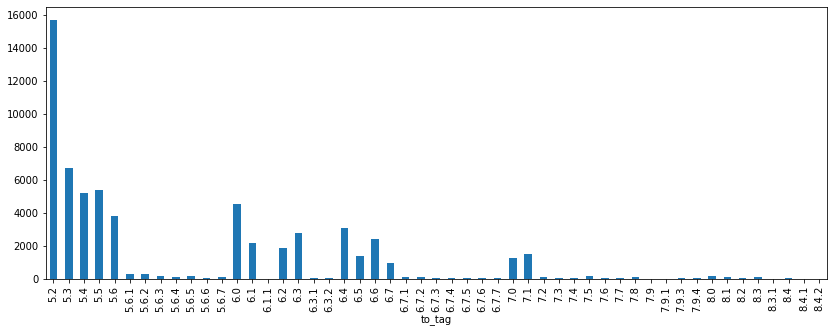

In [442]:
method1.groupby("to_tag").job_id.count().plot(kind="bar")

### Method 2

In [443]:
method2 = jobs_iterative_cherry_rebase
method2.shape

(210338, 3)

<AxesSubplot:xlabel='to_tag'>

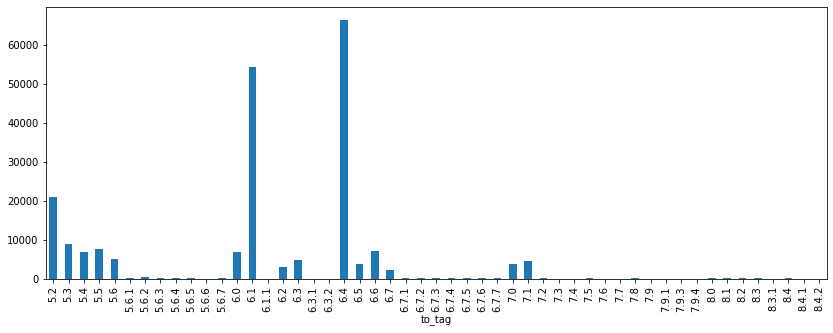

In [444]:
method2.groupby("to_tag").job_id.count().plot(kind="bar")

<AxesSubplot:xlabel='to_tag'>

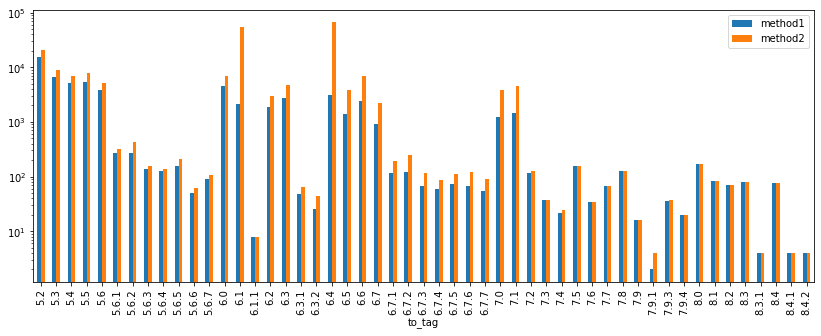

In [445]:
df_methods = method3.groupby("to_tag").job_id.count().reset_index()
df_methods["method1"] = method1.groupby("to_tag").job_id.count().values
df_methods["method2"] = method2.groupby("to_tag").job_id.count().values
df_methods.set_index("to_tag")[["method1", "method2"]].plot(kind="bar", logy=True)

# Start

In [446]:
def get_builds_from_commits(_commits):
    _build_ids = jobs[jobs.commitsha.isin(_commits)].buildid
    return builds[(builds.id.isin(_build_ids))]

def get_builds_from_jobs_ids(_release_jobs_ids):
    _build_ids = jobs[jobs.id.isin(_release_jobs_ids)].buildid
    return builds[(builds.id.isin(_build_ids))]

def get_builds_from_ids(_builds, _build_ids):
    return _builds[(_builds.id.isin(_build_ids))]

def get_job_ids_from_comparison_row(row, _jobs):
    _x = _jobs
    return _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id

def get_commits_from_comparison_row(row, commitsDf):
    _x = commitsDf
    return _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha

### Prepare 3 dataframes for the 3 commits methodologies

In [447]:
tc_direct_prs = tags_comparison.copy()
tc_iterative_cherry_rebase = tags_comparison.copy()

In [448]:
df_jobs = [(tc_direct_prs, method1, "direct_and_pr"),
(tc_iterative_cherry_rebase, method2, "iterative_pr_head_ref_cherry_picked")]

**Test**

In [449]:
_x =jobs_iterative_approach
_x[(_x.from_tag == "5.1.2") & (_x.to_tag == "5.2")].job_id

0        64092090
1        64092619
2        64094999
3        64095045
4        64095411
           ...   
21074    69417321
21075    69417322
21076    69417323
21077    69417324
21078    69417325
Name: job_id, Length: 21079, dtype: int64

### Builds metrics

**Percentage of builds per state**

In [450]:
def calculate_percentage_state_builds(row, release_jobs, state):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _all_builds = get_builds_from_jobs_ids(_jobs_ids)
    _builds = _all_builds[(_all_builds.state.isin(state))]
    if(len(_all_builds)==0):
        return 0
    return len(_builds)/len(_all_builds)

In [451]:
for state in ["passed", "canceled", "failed", "errored"]:
    for df, release_jobs, method in df_jobs:
        df[f"ratio_{state}_builds"] = \
        df.apply(calculate_percentage_state_builds, args=(release_jobs, [state]), axis=1)

<Figure size 1008x360 with 0 Axes>

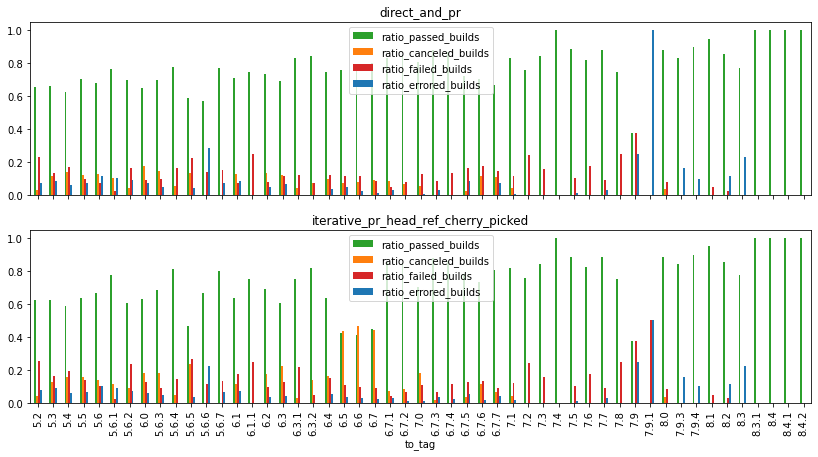

In [452]:
plt.figure()
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    cols = []
    for state in ["passed", "canceled", "failed", "errored"]:
        cols.append(f"ratio_{state}_builds")
    ax = df_job[0].set_index("to_tag")[cols].plot(ax=axes[i], kind="bar", color=["tab:green","tab:orange", "tab:red", "tab:blue"])
    ax.set_title(df_job[2])
plt.savefig(f"{figure_folder}/ci-metrics/percentage_state_builds.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Number of builds per pull request**

In [453]:
def calculate_percentage_pr_builds(row, release_jobs):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _all_builds = get_builds_from_jobs_ids(_jobs_ids)
    _builds = _all_builds[(_all_builds.event_type == "pull_request")]
    return len(_builds)/len(_all_builds)

In [454]:
for df, release_jobs, method in df_jobs:
    df[f"ratio_pr_builds"] = \
    df.apply(calculate_percentage_pr_builds, args=(release_jobs,), axis=1)

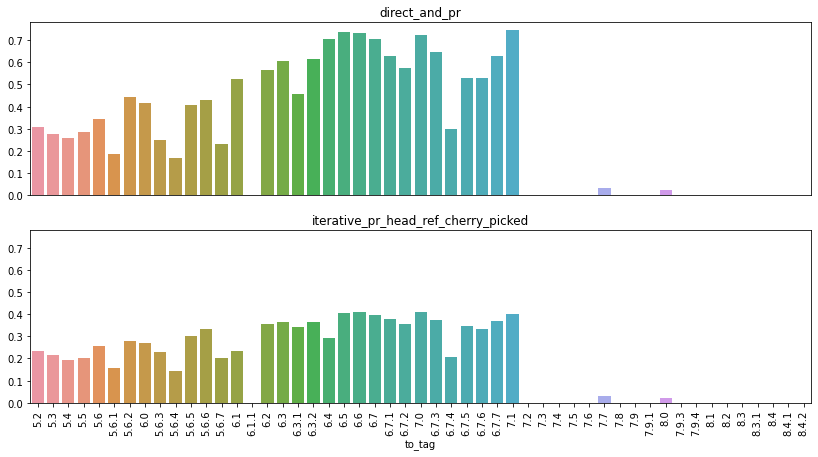

In [455]:
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, sharey=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    ax = sns.barplot(x=df_job[0].set_index("to_tag")["ratio_pr_builds"].index, \
                y=df_job[0]["ratio_pr_builds"].values, ax=axes[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(df_job[2])
    if(i < len(df_jobs) - 1):
        ax.get_xaxis().set_visible(False)

* 0% pull request builds may indicate mostly bug fixing done directly on the version branch. 
Indeed all the pairs with 0% do not represent major version upgrades

**Build duration for passed builds**

In [456]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_aggregator_build_duration(row, release_jobs, aggregator, state=None):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _all_builds = get_builds_from_jobs_ids(_jobs_ids)
    if(not state):
        _series = _all_builds.duration
    else:
        _series = _all_builds[_all_builds.state.isin(state)].duration
    res = getattr(_series, aggregator)()
    return res

In [457]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_all_build_duration"] = \
        df.apply(calculate_aggregator_build_duration, args=(release_jobs,agg), axis=1)
        
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_failed_build_duration"] = \
        df.apply(calculate_aggregator_build_duration, args=(release_jobs,agg, ["failed"]), axis=1)

for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_passed_build_duration"] = \
        df.apply(calculate_aggregator_build_duration, args=(release_jobs,agg, ["passed"]), axis=1)

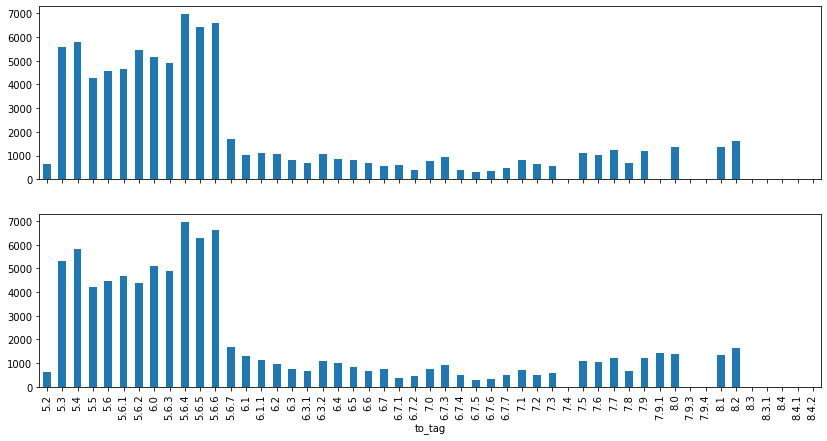

In [458]:
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, sharey=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    df_job[0].set_index("to_tag").\
        median_failed_build_duration.plot(kind="bar", ax=axes[i], color=["tab:blue"])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(df_job[2])
    if(i < len(df_jobs) - 1):
        ax.get_xaxis().set_visible(False)

**Number of builds per pull request**

In [459]:
### Mean or median of number of jobs per pull request
def calculate_aggregator_n_builds_per_pull_request(row, release_jobs, aggregator):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _jobs = jobs[jobs.id.isin(_jobs_ids)]
    _series = _jobs.groupby("commitref").buildid.nunique()
    res = getattr(_series, aggregator)()
    return res if not np.isnan(res) else 0

In [460]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_n_builds_per_pull_request"] = \
        df.apply(calculate_aggregator_n_builds_per_pull_request, args=(release_jobs,agg), axis=1)

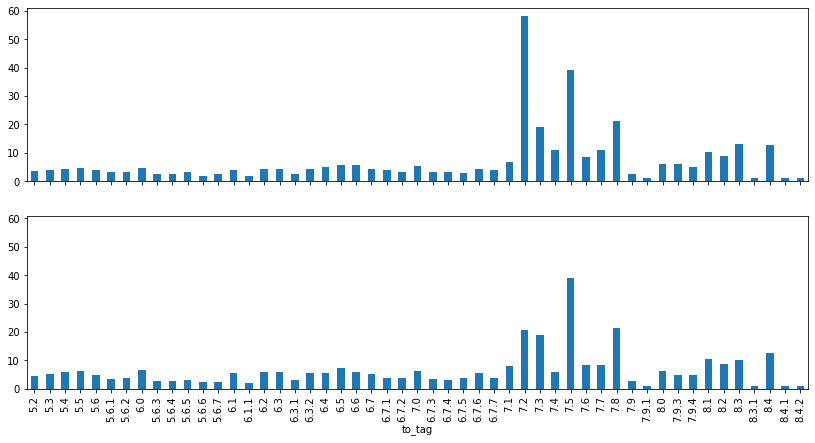

In [461]:
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, sharey=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    df_job[0].set_index("to_tag").\
        mean_n_builds_per_pull_request.plot(kind="bar", ax=axes[i], color=["tab:blue"])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(df_job[2])
    if(i < len(df_jobs) - 1):
        ax.get_xaxis().set_visible(False)

<ipython-input-462-cd09b00dd578>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df[method] = df[columns]
<ipython-input-462-cd09b00dd578>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df[method] = df[columns]
<ipython-input-462-cd09b00dd578>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

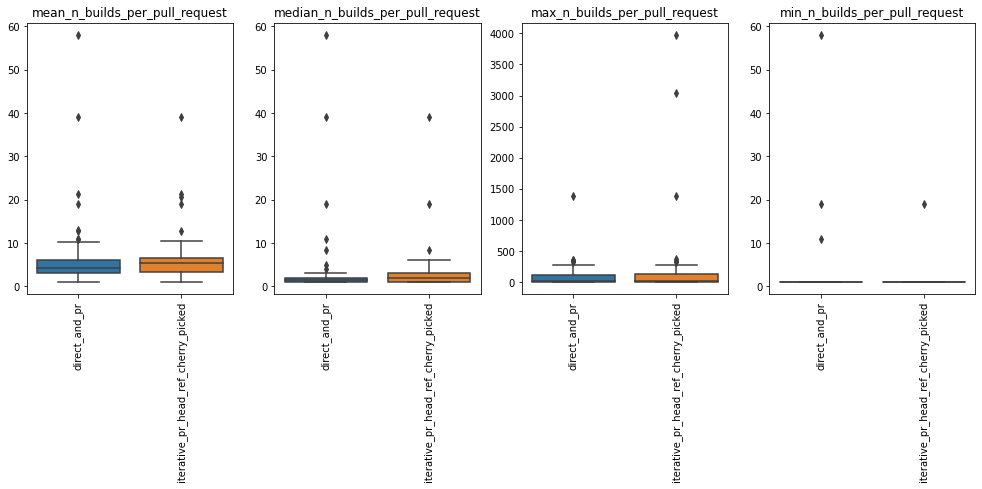

In [462]:
aggregators = ["mean", "median", "max", "min"]
fig, axes = plt.subplots(nrows=1, ncols=len(aggregators), sharex=True, figsize=(17.0, 5.0))
for i, agg in enumerate(aggregators):
    tmp_df = tags_comparison[["to_tag"]]
    columns = f"{agg}_n_builds_per_pull_request"
    for df, release_jobs, method in df_jobs:
        tmp_df[method] = df[columns]
    ax = sns.boxplot(data=tmp_df, ax=axes[i])
    ax.set_title(columns)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

**Number of builds per commitmessage**

### number of builds per pull request
def calculate_aggregator_n_builds_per_commitmessage(row, commitsDf, aggregator):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    _series = _jobs.groupby("commitmessage").buildid.nunique()
    res = getattr(_series, aggregator)()
    return res if not np.isnan(res) else 0
    
def calculate_aggregator_n_builds_per_commitmessage_per_commit_pr(row, aggregator):
    return calculate_aggregator_n_builds_per_commitmessage(row, tags_iterative_pr_commits, aggregator)
def calculate_aggregator_n_builds_per_commitmessage_per_commit_direct(row, aggregator):
    return calculate_aggregator_n_builds_per_commitmessage(row, tags_comparison_commits, aggregator)
def calculate_aggregator_n_builds_per_commitmessage_per_commit_fix(row, aggregator):
    return calculate_aggregator_n_builds_per_commitmessage(row, tags_fix_commits, aggregator)
def calculate_aggregator_n_builds_per_commitmessage_per_commit_pr_and_fix(row, aggregator):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_aggregator_n_builds_per_commitmessage(row, _tmp, aggregator)

for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_n_builds_per_commitmessage"] =\
    tags_comparison.apply(calculate_aggregator_n_builds_per_commitmessage_per_commit_pr_and_fix,\
                          args=(agg,), axis=1)

tags_comparison.max_n_builds_per_commitmessage.plot(kind="bar")

tags_comparison[["mean_n_builds_per_commitmessage", "median_n_builds_per_commitmessage"]].plot(kind="bar")

### Jobs metrics

**Average job duration**

jobs["duration"] = (jobs.finished_at - jobs.started_at) / np.timedelta64(1, "s")

### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_job_duration(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    return _jobs.duration.mean()

def calculate_average_job_duration_pr(row):
    return calculate_average_job_duration(row, tags_iterative_pr_commits)
def calculate_average_job_duration_direct(row):
    return calculate_average_job_duration(row, tags_comparison_commits)
def calculate_average_job_duration_fix(row):
    return calculate_average_job_duration(row, tags_fix_commits)

tags_comparison["mean_job_duration_builds_passed_or_failed"] = tags_comparison.apply(calculate_average_job_duration_pr, axis=1)

**Average failed jobs per commit**

### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_failed_job_per_commit(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    _jobs = _jobs[_jobs.state == "failed"]
    return _jobs.groupby("commitsha").state.count().mean()

def calculate_average_failed_job_per_commit_pr(row):
    return calculate_average_failed_job_per_commit(row, tags_iterative_pr_commits)
def calculate_average_failed_job_per_commit_direct(row):
    return calculate_average_failed_job_per_commit(row, tags_comparison_commits)
def calculate_average_failed_job_per_commit_fix(row):
    return calculate_average_failed_job_per_commit(row, tags_fix_commits)
def calculate_average_failed_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_failed_job_per_commit(row, _tmp)

tags_comparison["average_failed_job_per_commit"] = tags_comparison.apply(calculate_average_failed_job_per_commit_pr, axis=1)

sns.barplot(x=tags_comparison["average_failed_job_per_commit"].index, \
            y=tags_comparison["average_failed_job_per_commit"].values)

**Number of jobs canceled or errored**

### Mean or median of duration for jobs not from canceled or errored builds
def calculate_percentage_canceled_or_errored_job(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return len(_jobs[_jobs.state.isin(["canceled", "errored"])]) / len(_jobs)

def calculate_percentage_canceled_or_errored_job_per_commit_pr(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_iterative_pr_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_direct(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_comparison_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_fix(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_fix_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_canceled_or_errored_job(row, _tmp)

tags_comparison["percentage_canceled_or_errored_job"] =\
tags_comparison.apply(calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix, axis=1)

sns.barplot(x=tags_comparison["percentage_canceled_or_errored_job"].index, \
            y=tags_comparison["percentage_canceled_or_errored_job"].values)

**Is commitsha and commitref identical for all jobs associated with the same buildid?**

(jobs.groupby("buildid").commitsha.nunique() > 1).sum()

(jobs.groupby("buildid").commitref.nunique() > 1).sum()

Yes, therefore we can add this info to the build df

### Log parsing metrics

In [484]:
log_parsed_metrics = pd.read_csv(f"{csv_folder}/log_parsed_metrics_processed.csv", index_col=0)

In [485]:
log_parsed_metrics.head(3)

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,n_exceptions,n_error_classes,n_build_tools,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,year_month,errors_over_tests_total,failures_over_tests_total,skipped_over_tests_total
0,346751001,WEB_TESTS,['yarn'],False,3.0,2.0,1.0,2.0,1.0,1045.0,3294.0,[],[],1120.0,1117.0,0.0,3.0,[],['yarn'],0,0,1,False,False,False,False,False,True,False,346751001,346750998,2018-02-27 12:30:57+00:00,2018-02-27 12:30:21.579000+00:00,2018-02-27 12:34:24+00:00,37569.2,passed,2018-06-04 05:43:54.693000+00:00,7b245fbc45898ce11ab5cc0d60dc4f5621b94645,103144209,SONAR-10047 Use SearchSelect for tags in Bulk ...,refs/pull/3103/merge,https://github.com/SonarSource/sonarqube/pull/...,2018/02,0.002676,0.001784,0.000892
1,575471642,WEB_TESTS,"['yarn', 'jest', 'gradle']",False,3.0,2.0,1.0,9.0,1.0,1362.0,3919.0,[],[],2006.0,2005.0,0.0,1.0,[],"['yarn', 'jest', 'gradle']",0,0,3,False,True,False,True,False,True,False,575471642,575471639,2019-08-22 18:21:52+00:00,2019-08-22 18:21:19.464000+00:00,2019-08-22 18:33:18+00:00,39085.2,passed,2019-08-22 18:33:18.698000+00:00,7c2a234b30826c8f98dabff8506b1f49884b83a5,174121400,DOCS Add instructions for Application to a Por...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2019/08,0.001495,0.000997,0.000498
2,721125402,WEB_TESTS,"['yarn', 'gradle']",False,14.0,3.0,3.0,30.0,0.0,1426.0,4196.0,[],[],2412.0,2412.0,0.0,0.0,[],"['yarn', 'gradle']",0,0,2,False,True,False,False,False,True,False,721125402,721125400,2020-08-25 20:08:05+00:00,2020-08-25 20:06:58.581000+00:00,2020-08-25 20:18:58+00:00,39397.2,passed,2020-08-25 20:18:58.561000+00:00,60c64b2c9f95bb52d070758fa88a3881ae69b5e7,222268239,SONAR-13766 PostProjectAnalysisTask's 'descrip...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2020/08,0.005802,0.001243,0.000000


In [486]:
log_parsed_metrics.columns

Index(['job_id', 'build_target', 'build_tool',
       'build_canceled_open_pr_on_branch', 'errors', 'failures',
       'suspected_words', 'warnings', 'skipped_words', 'lines', 'words',
       'exceptions', 'error_classes', 'tests_total', 'tests_passed',
       'tests_failed', 'tests_skipped', 'failed_tasks', 'build_tool_str',
       'n_exceptions', 'n_error_classes', 'n_build_tools', 'maven_build',
       'gradle_build', 'mocha_build', 'jest_build', 'grunt_build',
       'yarn_build', 'node_build', 'id', 'buildid', 'started_at', 'created_at',
       'finished_at', 'number', 'state', 'updated_at', 'commitsha', 'commitid',
       'commitmessage', 'commitref', 'commitcompare_url', 'year_month',
       'errors_over_tests_total', 'failures_over_tests_total',
       'skipped_over_tests_total'],
      dtype='object')

In [487]:
def calculate_aggregator_for_column(row, release_jobs, column, aggregator):
    _x = release_jobs
    _jobs_ids = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].job_id
    _jobs = jobs[jobs.id.isin(_jobs_ids)]
    _series = log_parsed_metrics[log_parsed_metrics.job_id.isin(_jobs.id.unique())][column]
    return getattr(_series, aggregator)()

**Errors over tests**

In [488]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_errors_over_tests_total"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"errors_over_tests_total", agg), axis=1)

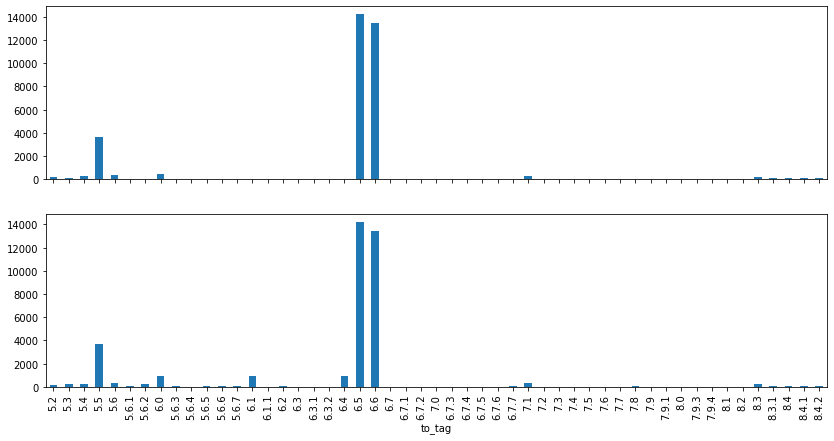

In [490]:
fig, axes = plt.subplots(nrows=len(df_jobs), ncols=1, sharex=True, sharey=True, figsize=(14.0, 7.0))
for i, df_job in enumerate(df_jobs):
    df_job[0].set_index("to_tag").\
        max_errors_over_tests_total.plot(kind="bar", ax=axes[i], color=["tab:blue"])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(df_job[2])
    if(i < len(df_jobs) - 1):
        ax.get_xaxis().set_visible(False)

**Failed tests**

In [491]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_failed_tests"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"tests_failed", agg), axis=1)

**Failures over total tests**

In [492]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_failures_over_tests_total"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"failures_over_tests_total", agg), axis=1)

**Skipped over tests**

In [493]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_skipped_over_tests_total"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"skipped_over_tests_total", agg), axis=1)

**Number of exceptions**

In [494]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_n_exceptions"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"n_exceptions", agg), axis=1)

**Number of warnings**

In [495]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_n_warnings"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"warnings", agg), axis=1)

**Number of error classes**


In [496]:
for agg in ["mean", "median", "max", "min"]:
    for df, release_jobs, method in df_jobs:
        df[f"{agg}_n_error_classes"] = \
        df.apply(calculate_aggregator_for_column, args=(release_jobs,"n_error_classes", agg), axis=1)

### Build burst metrics

In [374]:
builds_commitref = jobs.drop_duplicates(subset=["buildid", "commitref", "commitsha"], keep="first")[["buildid", "commitref", "commitsha"]]\
.merge(builds, left_on="buildid", right_on="id")
builds_commitref.head(40)

,buildid,commitref,commitsha,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,241946099,refs/heads/feature/atlas/MMF-324/builtin-profiles,2e4b539138fde6f664a865c81fb6ab0763f74bdb,25614,NaN,241946099,push,2017-06-12 09:21:43+00:00,NaN,2017-06-12 09:21:03+00:00,40.0,canceled,12.0,6.0,2017.0
1,241952022,refs/heads/feature/atlas/MMF-324/builtin-profiles,464f5da96733c14818f4b4bfeb878951b859ee0c,25615,NaN,241952022,push,2017-06-12 09:37:24+00:00,NaN,2017-06-12 09:36:43+00:00,40.0,canceled,12.0,6.0,2017.0
2,241952044,refs/pull/2104/merge,7358e9a93e47ac9fcaebe960c00ab8bd28e9890e,25616,2104.0,241952044,pull_request,2017-06-12 09:53:48+00:00,MMF-324 introduce concept of build-in Quality ...,2017-06-12 09:42:15+00:00,973.0,passed,12.0,6.0,2017.0
3,241955852,refs/heads/feature/jl/onboarding,00e86fd06991a1e54e3b17eb82f2532f85de6489,25617,NaN,241955852,push,2017-06-12 09:56:41+00:00,NaN,2017-06-12 09:50:40+00:00,610.0,failed,12.0,6.0,2017.0
4,241956721,refs/heads/feature/stas/onboarding/tutorial,b34d8845506f0de01138e525d118fe292d204334,25618,NaN,241956721,push,2017-06-12 09:51:07+00:00,NaN,2017-06-12 09:50:27+00:00,64.0,canceled,12.0,6.0,2017.0
5,241956741,refs/pull/2137/merge,0110c87fd42c510bb2c2f7a274d654a9fb07fb29,25619,2137.0,241956741,pull_request,2017-06-12 10:01:41+00:00,UI: SONAR-9355 Create onboarding tutorial,2017-06-12 09:50:05+00:00,1047.0,passed,12.0,6.0,2017.0
6,241963248,refs/heads/feature/jl/onboarding,8823b927339cbb7110f02c42bd12a04ea658897d,25620,NaN,241963248,push,2017-06-12 10:19:03+00:00,NaN,2017-06-12 10:08:56+00:00,885.0,passed,12.0,6.0,2017.0
7,241974640,refs/heads/feature/lambda/onboarding,fc4e2b219f729fd10dba979629ca79eeff0d726c,25621,NaN,241974640,push,2017-06-12 10:52:06+00:00,NaN,2017-06-12 10:51:28+00:00,75.0,canceled,12.0,6.0,2017.0
8,241974654,refs/pull/2133/merge,baf18566bc2af9cab1c72b851ce9e08d3714c731,25622,2133.0,241974654,pull_request,2017-06-12 11:07:10+00:00,MMF-886 Better first-time developer experience,2017-06-12 10:51:36+00:00,1360.0,passed,12.0,6.0,2017.0
9,241975118,refs/pull/2161/merge,939b617446ccc889408ea39ecf00e396443dcedb,25623,2161.0,241975118,pull_request,2017-06-12 11:10:44+00:00,SONAR-9356 Show onboarding tutorial only once ...,2017-06-12 10:54:03+00:00,1463.0,passed,12.0,6.0,2017.0


In [377]:
def detect_build_bursts(_builds, gap_size, burst_size, states):
    positive_count = 0
    negative_count = 0
    n_bursts = 0
    burst_sizes = []
    i = 0
    for index, row in _builds.sort_values(by="started_at").iterrows():
        i+=1
        if((i == len(_builds)) | (not (row.state in states))):
            negative_count+=1
            if(negative_count == gap_size):
                if(positive_count >= burst_size):
                    n_bursts+=1
                    burst_sizes.append(positive_count)
                negative_count = 0
                positive_count = 0
        if(row.state in states):
            positive_count+=1
    return n_bursts, burst_sizes

def build_burst_metrics(row, _release_jobs, states):
    _job_ids = get_job_ids_from_comparison_row(row, _release_jobs)
    _builds = get_builds_from_jobs_ids(_job_ids)
    _builds = builds_commitref[builds_commitref.id.isin(_builds.id)]
    res = {}
    for gap_size in [1,2,3]:
        for burst_size in [1,2,3]:
            commitref_data=[]
            for commitref in _builds.commitref.unique():
                _ref_builds = _builds[_builds.commitref==commitref]
                commitref_data.append(detect_build_bursts(_ref_builds, gap_size, burst_size, states))
            bursts = np.array([])
            bursts_sizes = np.array([])
            for d in commitref_data:
                bursts = np.append(bursts,d[0])
                for v in d[1]:
                    bursts_sizes = np.append(bursts_sizes,v)
            if not gap_size in res:
                res[gap_size] = {}
            res[gap_size][burst_size] = (bursts, bursts_sizes)
    return res

def get_failed_burst_metrics(row, _release_jobs):
    return build_burst_metrics(row, _release_jobs, ["failed"])

def get_canceled_burst_metrics(row, _release_jobs):
    return build_burst_metrics(row, _release_jobs, ["canceled"])

def get_not_passed_burst_metrics(row, _release_jobs):
    return build_burst_metrics(row, _release_jobs, ["failed", "canceled", "errored"])

In [396]:
def burst_metrics_analysis(burst_metrics, type_str):
    cols = ["index"]
    data = []
    for i, row in burst_metrics.items():
        inner_data = [i]
        for gap in row:
            for burst_size in row[gap]:
                bursts = row[gap][burst_size][0]
                burst_sizes = row[gap][burst_size][1]
                inner_data.append(bursts.mean())
                inner_data.append(np.median(bursts))
                inner_data.append(bursts.max())
                inner_data.append(bursts.min())
                if(i == 3):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_n_bursts_{metric}")
                inner_data.append(burst_sizes.mean())
                inner_data.append(np.median(burst_sizes))
                inner_data.append(np.max(burst_sizes, initial=0))
                inner_data.append(np.min(burst_sizes, initial=0))
                if(i == 3):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_burst_size_{metric}")
        data.append(tuple(inner_data))
    return data, cols

**Not passed burst metrics**

not_passed_burst_metrics = {}
for df, release_jobs, method in df_jobs:
    metrics = df.apply(get_not_passed_burst_metrics,args=(release_jobs,),axis=1)
    not_passed_burst_metrics[method]=metrics

df_jobs_bursts = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs):
    data, cols = burst_metrics_analysis(not_passed_burst_metrics["iterative_pr_head_ref_cherry_picked"], "not_passed")
    not_passed_burst_metrics_df = pd.DataFrame(data, columns=cols)
    not_passed_burst_metrics_df.set_index("index", inplace=True)
    not_passed_burst_metrics_df.fillna(0, inplace=True)
    df_jobs_bursts[i] = (df.join(not_passed_burst_metrics_df), release_jobs, method)

#checkpoint of calculation up until here
for df_burst, release_jobs, method in df_jobs_bursts: 
    df_burst.to_csv(f"{csv_folder}/ci_metrics/{method}_not_passed_burst_metrics.csv")

#retrieve checkpoint of calculation up until here
df_jobs_bursts = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs): 
    tmp = pd.read_csv(f"{csv_folder}/ci_metrics/{method}_not_passed_burst_metrics.csv", index_col=0)
    df_jobs_bursts[i] = (tmp, release_jobs, method)

**Canceled burst metrics**

cenceled_burst_metrics = {}
for df, release_jobs, method in df_jobs_bursts:
    metrics = df.apply(get_canceled_burst_metrics,args=(release_jobs,),axis=1)
    cenceled_burst_metrics[method]=metrics

In [472]:
for i, (df, release_jobs, method) in enumerate(df_jobs_bursts):
    data, cols = burst_metrics_analysis(not_passed_burst_metrics["iterative_pr_head_ref_cherry_picked"], "canceled")
    not_passed_burst_metrics_df = pd.DataFrame(data, columns=cols)
    not_passed_burst_metrics_df.set_index("index", inplace=True)
    not_passed_burst_metrics_df.fillna(0, inplace=True)
    df_jobs_bursts[i] = (df.join(not_passed_burst_metrics_df), release_jobs, method)

<ipython-input-396-81977db1af73>:17: RuntimeWarning: Mean of empty slice.
  inner_data.append(burst_sizes.mean())
/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


#checkpoint of calculation up until here
for df_burst, release_jobs, method in df_jobs_bursts: 
    df_burst.to_csv(f"{csv_folder}/ci_metrics/{method}_not_passed_+_canceled_burst_metrics.csv")

#retrieve checkpoint of calculation up until here
df_jobs_bursts = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs): 
    tmp = pd.read_csv(f"{csv_folder}/ci_metrics/{method}_not_passed_+_canceled_burst_metrics.csv", index_col=0)
    df_jobs_bursts[i] = (tmp, release_jobs, method)

**Failed burst metrics**

failed_burst_metrics = {}
for df, release_jobs, method in df_jobs_bursts:
    metrics = df.apply(get_failed_burst_metrics,args=(release_jobs,),axis=1)
    cenceled_burst_metrics[method]=metrics

for i, (df, release_jobs, method) in enumerate(df_jobs_bursts):
    data, cols = burst_metrics_analysis(not_passed_burst_metrics["iterative_pr_head_ref_cherry_picked"], "failed")
    not_passed_burst_metrics_df = pd.DataFrame(data, columns=cols)
    not_passed_burst_metrics_df.set_index("index", inplace=True)
    not_passed_burst_metrics_df.fillna(0, inplace=True)
    df_jobs_bursts[i] = (df.join(not_passed_burst_metrics_df), release_jobs, method)

#checkpoint of calculation up until here
for df_burst, release_jobs, method in df_jobs_bursts: 
    df_burst.to_csv(f"{csv_folder}/ci_metrics/{method}_all_burst_metrics.csv")

#retrieve checkpoint of calculation up until here
df_jobs_bursts = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs): 
    tmp = pd.read_csv(f"{csv_folder}/ci_metrics/{method}_all_burst_metrics.csv", index_col=0)
    df_jobs_bursts[i] = (tmp, release_jobs, method)

**Software quality metrics**

In [499]:
sw_quality_metrics= pd.read_csv(f"{csv_folder}/tags_software_quality_metrics_no_rc_and_milestones.csv", index_col=0)
sw_quality_metrics.head(2)

,version_name,post_release_bugs,pre_release_bugs,pre_release_after_tagging_bugs,dde,critical_post_release_bugs,minor_post_release_bugs,fix_time
0,4.5.7,1,0.0,0.0,0.000000,0.0,0.0,-434.28603
1,5.1,24,2.0,4.0,0.076923,0.0,2.0,-60.53169


In [500]:
sw_quality_metrics.columns

Index(['version_name', 'post_release_bugs', 'pre_release_bugs',
       'pre_release_after_tagging_bugs', 'dde', 'critical_post_release_bugs',
       'minor_post_release_bugs', 'fix_time'],
      dtype='object')

**Merging**

In [503]:
df_jobs_sw_metrics = [(),()]
for i, (df, release_jobs, method) in enumerate(df_jobs):
    dataset_with_sw_metrics = df.merge(sw_quality_metrics, left_on="to_tag", right_on="version_name")
    df_jobs_sw_metrics[i] = (dataset_with_sw_metrics, release_jobs, method)
    dataset_with_sw_metrics.to_csv(f"{csv_folder}/final_datasets/{method}_with_sw_metrics.csv")

**Extracting the dependent variables** 

In [177]:
tags_comparison_with_metrics_y=tags_comparison_with_metrics[["post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]]

In [178]:
tags_comparison_with_metrics_y.columns

Index(['post_release_bugs', 'fix_time', 'dde', 'critical_post_release_bugs',
       'minor_post_release_bugs'],
      dtype='object')

**Extracting the independent variables**

In [179]:
tags_comparison_with_metrics_x = tags_comparison_with_metrics.drop(columns=['from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag'])
tags_comparison_with_metrics_x = tags_comparison_with_metrics_x.drop(columns=['version_name','post_release_bugs', 'dde', 'critical_post_release_bugs',
       'minor_post_release_bugs', 'fix_time'])

In [180]:
tags_comparison_with_metrics_x.columns

Index(['ratio_passed_builds', 'ratio_canceled_builds', 'ratio_failed_builds',
       'ratio_errored_builds', 'ratio_pr_builds', 'mean_all_build_duration',
       'median_all_build_duration', 'max_all_build_duration',
       'min_all_build_duration', 'mean_failed_build_duration',
       ...
       'canceled_gp3_bs3_n_bursts_mean', 'canceled_gp3_bs3_n_bursts_median',
       'canceled_gp3_bs3_n_bursts_max', 'canceled_gp3_bs3_n_bursts_min',
       'canceled_gp3_bs3_burst_size_mean',
       'canceled_gp3_bs3_burst_size_median', 'canceled_gp3_bs3_burst_size_max',
       'canceled_gp3_bs3_burst_size_min', 'pre_release_bugs',
       'pre_release_after_tagging_bugs'],
      dtype='object', length=267)

**Correlation**

In [181]:
corr_x = tags_comparison_with_metrics_x.corr()

In [182]:
corr_x.loc["canceled_gp3_bs3_n_bursts_mean"][corr_x.loc["canceled_gp3_bs3_n_bursts_mean"] > 0.8]

canceled_gp1_bs3_n_bursts_mean    0.811390
canceled_gp2_bs2_n_bursts_mean    0.812558
canceled_gp2_bs3_n_bursts_mean    0.903717
canceled_gp3_bs3_n_bursts_mean    1.000000
Name: canceled_gp3_bs3_n_bursts_mean, dtype: float64

**Check for normal distribution**

In [183]:
alpha = 0.05

In [184]:
k2, p_val = stats.normaltest(tags_comparison_with_metrics_x)

In [185]:
cols = tags_comparison_with_metrics_x.columns

In [186]:
cols[p_val > alpha]

Index(['mean_n_builds_per_pull_request', 'mean_n_exceptions',
       'canceled_gp2_bs1_n_bursts_mean'],
      dtype='object')

### Spearman correlation with Number of post release bugs
https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide-2.php#:~:text=The%20Spearman%20correlation%20coefficient%2C%20rs%2C%20can%20take%20values%20from,the%20association%20between%20the%20ranks.

In [187]:
data = []
for col in tags_comparison_with_metrics_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_with_metrics_x[f"{col}"],tags_comparison_with_metrics_y.post_release_bugs)
    data.append((col, corr, p_val))
spearman_corr_post_release_bugs_df = pd.DataFrame(data, columns=["metric", "corr", "p_val"])

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


top_spearm = spearman_corr_post_release_bugs_df[spearman_corr_post_release_bugs_df.p_val< 0.05].sort_values(by="corr", ascending=False)
print(top_spearm[~top_spearm.metric.str.contains("pre_release")].head(10).to_latex(index=False))

print( top_spearm[(~top_spearm.metric.str.contains("pre_release")) & (~top_spearm.metric.str.contains("burst"))].head(10).to_latex(index=False))

In [212]:
top_spearm[(~top_spearm.metric.str.contains("pre_release")) & (~top_spearm.metric.str.contains("burst"))].head(10)

,metric,corr,p_val
27,max_failed_tests,0.576088,0.000015
25,mean_failed_tests,0.547622,0.000047
31,max_failures_over_tests_total,0.441308,0.001503
39,max_n_exceptions,0.422700,0.002480
47,max_n_error_classes,0.409754,0.003458
19,max_n_builds_per_pull_request,0.370912,0.008699
35,max_skipped_over_tests_total,0.360732,0.010887
23,max_errors_over_tests_total,0.352604,0.012959
43,max_n_warnings,0.346307,0.014788
7,max_all_build_duration,0.315716,0.027118


<AxesSubplot:xlabel='post_release_bugs', ylabel='max_failed_tests'>

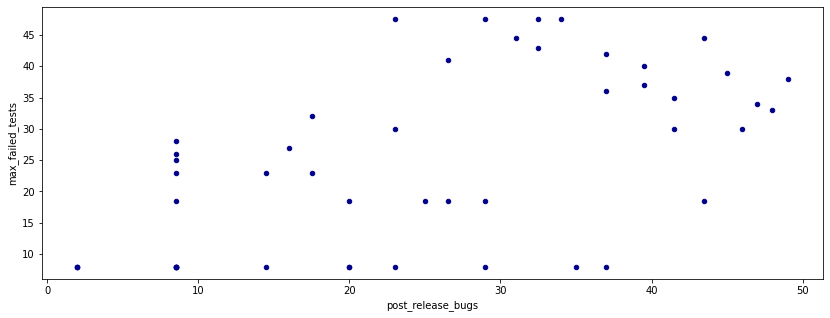

In [207]:
x = pd.DataFrame({"post_release_bugs": tags_comparison_with_metrics.post_release_bugs.rank(),
                  "max_failed_tests": tags_comparison_with_metrics.max_failed_tests.rank()})
x.plot.scatter(x="post_release_bugs", y="max_failed_tests", c='DarkBlue')

<AxesSubplot:xlabel='post_release_bugs', ylabel='canceled_gp3_bs3_n_bursts_max'>

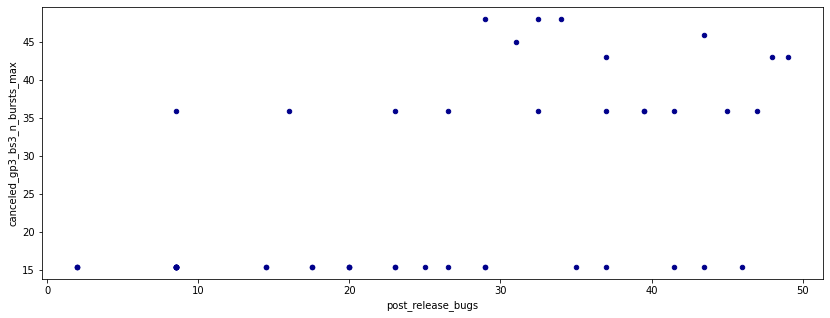

In [210]:
x = pd.DataFrame({"post_release_bugs": tags_comparison_with_metrics.post_release_bugs.rank(),
                  "canceled_gp3_bs3_n_bursts_max": tags_comparison_with_metrics.canceled_gp3_bs3_n_bursts_max.rank()})
x.plot.scatter(x="post_release_bugs", y="canceled_gp3_bs3_n_bursts_max", c='DarkBlue')

### Spearman correlation with Fix Time

In [ ]:
data = []
for col in tags_comparison_with_metrics_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_with_metrics_x[f"{col}"],tags_comparison_with_metrics_y.fix_time)
    data.append((col, corr, p_val))
spearman_corr_fix_time_df = pd.DataFrame(data, columns=["metric", "corr", "p_val"])

In [ ]:
spearman_corr_fix_time_df[spearman_corr_fix_time_df.p_val< 0.05].sort_values(by="corr", ascending=False)

### Spearman correlation with DDE

In [ ]:
data = []
for col in tags_comparison_with_metrics_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_x[f"{col}"],tags_comparison_with_metrics_y.dde)
    data.append((col, corr, p_val))
spearman_corr_dde_df = pd.DataFrame(data, columns=["metric", "corr", "p_val"])

In [ ]:
spearman_corr_dde_df[spearman_corr_dde_df.p_val< 0.05].sort_values(by="corr", ascending=False)

## Features types

## ML

In [217]:
X_train = tags_comparison_with_metrics_x

In [218]:
from sklearn import preprocessing

In [220]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [221]:
scaler.transform(X_train)

array([[-3.62850881, -0.90083371,  5.75420084, ...,  0.        ,
        -0.62284655, -0.50167092],
       [-0.40151633, -0.55895307,  0.84634212, ...,  0.        ,
         0.11256263,  2.01238447],
       [-0.51611015,  0.16448049,  0.37963883, ...,  0.        ,
         0.48026722,  0.05700806],
       ...,
       [ 1.59945034, -0.90083371, -0.94170058, ...,  0.        ,
        -0.62284655, -0.50167092],
       [ 1.59945034, -0.90083371, -0.94170058, ...,  0.        ,
         0.48026722,  0.05700806],
       [ 1.59945034, -0.90083371, -0.94170058, ...,  0.        ,
        -0.62284655, -0.50167092]])